In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from urllib import request
from collections import Counter
from ast import literal_eval

import numpy as np
import pandas as pd
import logging
import re
import html

import torch
from matplotlib import pyplot as plt
from torch.nn import CrossEntropyLoss, functional
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments

)
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [3]:
# check gpu

cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Cuda available?  True


# Setup from before

In [4]:
num_models = 4
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [5]:
# load pcl dataset

data_path = "/content/drive/MyDrive/pcl_datasets/dontpatronizeme_pcl.tsv"
cols = ["id", "par_id", "keyword", "country", "text", "label"]

df = pd.read_csv(data_path, sep="\t", names=cols, header=None, skiprows=3)
df.head(300)

,id,par_id,keyword,country,text,label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0
2,3,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0
4,5,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0
...,...,...,...,...,...,...
295,296,@@19617986,immigrant,ie,They 'll hardly have that place cleaned in tim...,0
296,297,@@20497185,refugee,my,Then there are those who support German Chance...,0
297,298,@@1958113,homeless,tz,New Dar master plan to render millions homeless,0
298,299,@@10033865,disabled,ke,While speaking in Eldoret during an interview ...,0


In [6]:
# update labels: class 0-1 are non-PCL, class 2-4 are PCL

df["binary_label"] = (df["label"] >= 2).astype(int)
df["binary_label"].value_counts()


,count
binary_label,
0,9476
1,993


In [7]:
na_indices = df[df.isna().any(axis=1)].index
print(na_indices.tolist())
print(df[df.isna().any(axis=1)])

[8639]
        id      par_id  keyword country text  label  binary_label
8639  8640  @@16852855  migrant      ke  NaN      0             0


In [8]:
# fill na entries with empty string

print(f"Before handling na: {df['text'].isna().sum()}")
df["text"] = df["text"].fillna("")
print(f"After handling na: {df['text'].isna().sum()}")

Before handling na: 1
After handling na: 0


In [9]:
# remove special characters

def clean_special_chars(text):
    text = html.unescape(text)
    text = text.replace('\n', ' ').replace('\t', ' ')
    return " ".join(text.split())

df['text'] = df['text'].apply(clean_special_chars)

print(df[df["text"].str.contains(r"&amp;|\n|\t", regex=True)].shape[0])

0


In [10]:
# set up dataframes
# set aside dev, acts as a soft evaluation set
# split remaining dataset into train and validation sets

rand_state = 63

train_ids = pd.read_csv("/content/drive/MyDrive/pcl_datasets/train_semeval_parids-labels.csv")
dev_ids = pd.read_csv("/content/drive/MyDrive/pcl_datasets/dev_semeval_parids-labels.csv")

train_ids = train_ids.rename(columns={"par_id": "id"})
dev_ids = dev_ids.rename(columns={"par_id": "id"})

temp_df = df.merge(train_ids, on="id")
temp_df = temp_df[["id", "keyword", "text", "binary_label"]]

train_df, val_df = train_test_split(
    temp_df,
    test_size=0.2,
    stratify=temp_df["binary_label"],
    random_state=rand_state
)

# done retrospectively to ensure dev labels align correctly
dev_df = dev_ids.merge(df, on="id", how="left")
dev_df = dev_df[["id", "keyword", "text", "binary_label"]]

In [11]:
(dev_df["id"].values == dev_ids["id"].values).all()

np.True_

In [12]:
len(dev_df)

2094

In [13]:
# dataset class for huggingface Trainer

class PCLDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=192):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=max_length
        )
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item


In [14]:
# set different max sequence lengths

train_datasets = []
val_datasets = []
dev_datasets = []
max_lengths = [128, 128, 192, 256]

for i in range(num_models):
    train_dataset = PCLDataset(
        train_df["text"].tolist(),
        train_df["binary_label"].tolist(),
        tokenizer,
        max_length=max_lengths[i]
    )

    val_dataset = PCLDataset(
        val_df["text"].tolist(),
        val_df["binary_label"].tolist(),
        tokenizer,
        max_length=max_lengths[i]
    )

    dev_dataset = PCLDataset(
        dev_df["text"].tolist(),
        dev_df["binary_label"].tolist(),
        tokenizer,
        max_length=max_lengths[i]
    )

    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)
    dev_datasets.append(dev_dataset)



# Exercise 5

## 5.2 Local Evaluation

In [15]:
# dev set evaluation

dev_labels = np.array(dev_df["binary_label"].tolist())
all_probs = []

training_args = TrainingArguments(
    output_dir="./tmp_eval",
    per_device_eval_batch_size=32,
    do_train=False,
    do_eval=False,
    logging_strategy="no"
)

for i in range(num_models):
    model_path = f"/content/drive/MyDrive/roberta_pcl_model_a_{i}"
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    trainer = Trainer(
        model=model,
        args=training_args,
    )

    preds = trainer.predict(dev_datasets[i])
    logits = preds.predictions

    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    all_probs.append(probs)


all_probs = np.array(all_probs)
ensemble_probs = np.mean(all_probs, axis=0)
threshold = 0.3750

ensemble_preds = (ensemble_probs >= threshold).astype(int)

print(classification_report(dev_labels, ensemble_preds, digits=4))


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:01<?, ?it/s]

              precision    recall  f1-score   support

           0     0.9646    0.9478    0.9561      1895
           1     0.5733    0.6683    0.6172       199

    accuracy                         0.9212      2094
   macro avg     0.7689    0.8080    0.7866      2094
weighted avg     0.9274    0.9212    0.9239      2094



### 1. Error Analysis

In [16]:
analysis_df = dev_df.copy().reset_index(drop=True)

analysis_df["prob"] = ensemble_probs
analysis_df["pred"] = ensemble_preds
analysis_df["true"] = dev_labels

def get_error_type(row):
    if row["true"] == 1 and row["pred"] == 1:
        return "TP"
    elif row["true"] == 0 and row["pred"] == 0:
        return "TN"
    elif row["true"] == 0 and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

analysis_df["error_type"] = analysis_df.apply(get_error_type, axis=1)


In [ ]:
fps = analysis_df[analysis_df["error_type"] == "FP"]
fps = fps.sort_values("prob", ascending=False)

fns = analysis_df[analysis_df["error_type"] == "FN"]
fns = fns.sort_values("prob")

for i, row in fps.head(30).iterrows():
    print(f"Index: {i}")
    print(f"Prob: {row['prob']:.4f}")
    print(f"Keyword: {row['keyword']}")
    print(f"True label: {row['true']} | Pred: {row['pred']}")
    print(f"Text: {row["text"]}")
    print("\n")

print("Top False Positive keyword counts:")
display(fps["keyword"].value_counts())

for i, row in fns.head(30).iterrows():
    print(f"Index: {i}")
    print(f"Prob: {row['prob']:.4f}")
    print(f"Keyword: {row['keyword']}")
    print(f"True label: {row['true']} | Pred: {row['pred']}")
    print(f"Text: {row["text"]}")
    print("\n")

print("Top False Negative keyword counts:")
display(fns["keyword"].value_counts())


Index: 740
Prob: 0.9494
Keyword: in-need
True label: 0 | Pred: 1
Text: Jesus begins his teaching in Matthew with the Sermon on the Mount . One group he blesses is those in need of comfort , Blessed are they who mourn , for they will be comforted ( Mt 5:4 ) .


Index: 1148
Prob: 0.9369
Keyword: in-need
True label: 0 | Pred: 1
Text: Christmas is celebration of the birth of not merely a child , but a child who changed the destiny of humans forever . It is celebration of the fact that God wanted to be a part of the human race and so he took on flesh and blood and became human like us . We can also show unconditional love through our good deeds and helping those who are in need of our help and care . Be human and merciful .


Index: 614
Prob: 0.9277
Keyword: in-need
True label: 0 | Pred: 1
Text: " I always consider this job as a gift , being a nurse is a reward and task given by God to help those who are in need . Seeing your patient recover from an illness , watching their families smile w

,count
keyword,
homeless,21
poor-families,19
in-need,17
hopeless,16
vulnerable,10
refugee,7
women,5
disabled,4


Index: 18
Prob: 0.0166
Keyword: poor-families
True label: 1 | Pred: 0
Text: The World Health Organization did not give a reason for the increase in deaths , but a provincial health official in Sindh said that the disease hit areas where poor families did not vaccinate their children .


Index: 67
Prob: 0.0167
Keyword: homeless
True label: 1 | Pred: 0
Text: It 's calculated that over 204,000 days of purpose-built residential accommodation to otherwise potentially homeless elderly men and women have been delivered by this personally driven altruistic act alone .


Index: 117
Prob: 0.0198
Keyword: disabled
True label: 1 | Pred: 0
Text: Cheung said 20 disabled undergraduate students from seven universities will start their eight-week internship in government departments this month , receiving the same salaries as able-bodied colleagues of HK$9,600 a month .


Index: 71
Prob: 0.0220
Keyword: vulnerable
True label: 1 | Pred: 0
Text: He said : " I think we can consider introducing a negligibl

,count
keyword,
poor-families,12
hopeless,10
homeless,9
women,8
vulnerable,7
disabled,6
immigrant,5
refugee,4
migrant,3


In [ ]:
tps = analysis_df[analysis_df["error_type"] == "TP"]
tps = tps.sort_values("prob", ascending=False)

tns = analysis_df[analysis_df["error_type"] == "TN"]
tns = tns.sort_values("prob")

for i, row in tps.head(60).iterrows():
    print(f"Index: {i}")
    print(f"Prob: {row['prob']:.4f}")
    print(f"Keyword: {row['keyword']}")
    print(f"True label: {row['true']} | Pred: {row['pred']}")
    print(f"Text: {row["text"]}")
    print("\n")

print("Top True Positive keyword counts:")
display(tps["keyword"].value_counts())

for i, row in tns.head(500).iterrows():
    print(f"Index: {i}")
    print(f"Prob: {row['prob']:.4f}")
    print(f"Keyword: {row['keyword']}")
    print(f"True label: {row['true']} | Pred: {row['pred']}")
    print(f"Text: {row["text"]}")
    print("\n")

print("Top True Negative keyword counts:")
display(tns["keyword"].value_counts())


Index: 36
Prob: 0.9664
Keyword: in-need
True label: 1 | Pred: 1
Text: Fasting bridges the gap between rich and poor , sustained and impoverished , fulfilled and needy . This experience should then inspire compassion and mercy , which is manifest by generosity of wealth and time to help those in need .


Index: 6
Prob: 0.9559
Keyword: hopeless
True label: 1 | Pred: 1
Text: The Word of God is truth that 's living and able to penetrate human souls ( Heb. 4:12 ) . Consider how powerful Scripture is : it can change hearts , save lives from eternal condemnation , and give hope to the hopeless .


Index: 62
Prob: 0.9540
Keyword: in-need
True label: 1 | Pred: 1
Text: Kenyans are known to have big hearts . Hearts so big that they give generously when it comes those in need . Despite all our differences , we unite to help the sick , fight for justice or feed those in drought or war-stricken areas .


Index: 65
Prob: 0.9519
Keyword: in-need
True label: 1 | Pred: 1
Text: We have the opportunity to

,count
keyword,
in-need,31
poor-families,26
homeless,20
hopeless,16
vulnerable,13
refugee,9
disabled,8
women,6
migrant,2


Index: 1299
Prob: 0.0087
Keyword: immigrant
True label: 0 | Pred: 0
Text: Data from the US department of state , however , shows that 3,211 permanent resident visas were issued by the US embassy in Nairobi in the 2012 fiscal year compared to 4,024 immigrant visas in the previous year and 4,741 in 2010 .


Index: 964
Prob: 0.0091
Keyword: vulnerable
True label: 0 | Pred: 0
Text: He said the objectives of the project are to determine steps in the supply chain that was most vulnerable to development of aflatoxin and practices that influenced aflatoxin contamination in peanut , to carry out detailed comparisons of pest management , production , and field drying practices on aflatoxin contamination in peanut and to evaluate peanut germplasm for resistance to aflatoxin and other biotic stress factors such as leaf spot diseases .


Index: 1321
Prob: 0.0091
Keyword: migrant
True label: 0 | Pred: 0
Text: This was a major arrival port for immigrants coming to Canada in the middle of the 19 th ce

,count
keyword,
women,214
immigrant,211
migrant,202
vulnerable,179
disabled,176
in-need,176
hopeless,175
refugee,168
homeless,162


In [ ]:
# Count keyword occurrences per error type
keyword_outcome_counts = (
    analysis_df
    .groupby(["keyword", "error_type"])
    .size()
    .unstack(fill_value=0)
)

# Ensure consistent column order
for col in ["TP", "FP", "FN"]:
    if col not in keyword_outcome_counts.columns:
        keyword_outcome_counts[col] = 0

keyword_outcome_counts = keyword_outcome_counts[["TP", "FP", "FN"]]

# Optional: sort by total frequency
keyword_outcome_counts["total"] = keyword_outcome_counts.sum(axis=1)
keyword_outcome_counts = keyword_outcome_counts.sort_values("total", ascending=False)
keyword_outcome_counts = keyword_outcome_counts.drop(columns="total")

keyword_outcome_counts.head(10)

error_type,TP,FP,FN
keyword,,,
poor-families,26,19,12
homeless,20,21,9
in-need,31,17,2
hopeless,16,16,10
vulnerable,13,10,7
refugee,9,7,4
women,6,5,8
disabled,8,4,6
immigrant,2,0,5


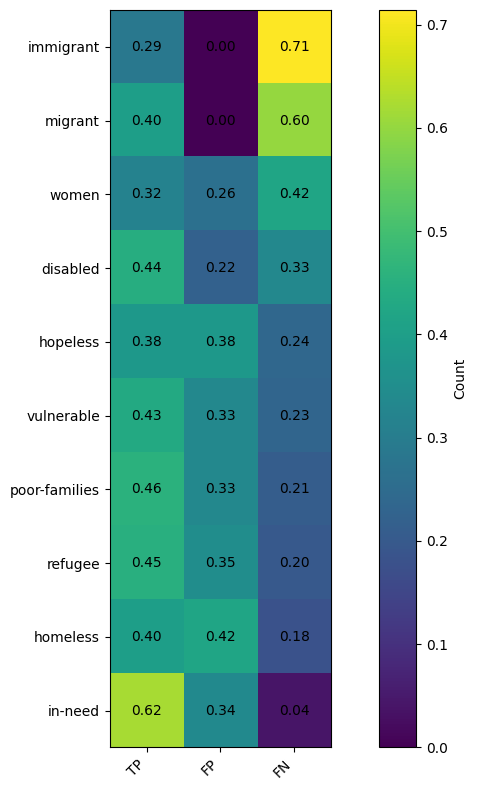

In [ ]:
# Convert counts to proportions per keyword
df_plot = keyword_outcome_counts.div(
    keyword_outcome_counts.sum(axis=1),
    axis=0
)

# min_count = 10
# valid_keywords = keyword_outcome_counts.sum(axis=1) >= min_count
# df_plot = df_plot[valid_keywords]

df_plot = df_plot.sort_values("FN", ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(df_plot.values)

# Colorbar
cbar = plt.colorbar(im)
cbar.set_label("Count")

# Axis ticks
ax.set_xticks(np.arange(len(df_plot.columns)))
ax.set_yticks(np.arange(len(df_plot.index)))

ax.set_xticklabels(df_plot.columns)
ax.set_yticklabels(df_plot.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Annotate values
for i in range(len(df_plot.index)):
    for j in range(len(df_plot.columns)):
        ax.text(j, i, f"{df_plot.iloc[i, j]:.2f}",
                ha="center", va="center", color="black")

plt.tight_layout()
plt.show()


In [18]:
analysis_df["num_words"] = df["text"].str.split().apply(len)

In [21]:
analysis_df[analysis_df["num_words"] <= 7]

,id,keyword,text,binary_label,prob,pred,true,error_type,num_words
214,8402,homeless,Clashes left 300 villagers homeless in Khagrac...,0,0.014064,0,0,TN,7
271,8462,immigrant,138 Tanzanians mistaken for illegal immigrants,0,0.013710,0,0,TN,6
397,8598,refugee,Close <h> Climate change refugee loses bid,0,0.023165,0,0,TN,7
434,8640,migrant,,0,0.207709,0,0,TN,0
817,9064,hopeless,Feeling hopeless,0,0.097286,0,0,TN,2
862,9114,vulnerable,Govt urged to support vulnerable children,0,0.029633,0,0,TN,6
880,9135,refugee,Syrian refugee children .,0,0.046239,0,0,TN,4
973,9230,homeless,Heavy rains render l8 families homeless,0,0.022541,0,0,TN,6
1288,9572,refugee,UN protests Cameroon expulsion of Nigeria refu...,0,0.014600,0,0,TN,7
1363,9656,women,Diet for women over 30 :,0,0.024265,0,0,TN,6


In [23]:
analysis_df[analysis_df["num_words"] >= 150]

,id,keyword,text,binary_label,prob,pred,true,error_type,num_words
17,6189,women,Our country is in need of serious change . We ...,1,0.103540,0,1,FN,175
23,1208,vulnerable,It is written in Ecclessiastes in the Bible th...,1,0.903671,1,1,TP,165
391,8592,hopeless,The five-person structure that works well enou...,0,0.018313,0,0,TN,160
444,8650,immigrant,Now a year after inauguration as America 's Pr...,0,0.015574,0,0,TN,163
644,8872,women,"About OvaScienceOvaScienceSM , Inc. is a globa...",0,0.019139,0,0,TN,151
696,8929,poor-families,"If the situation is worsening in the cities , ...",0,0.431735,1,0,FP,153
1207,9485,migrant,When the potato famine sent droves of immigran...,0,0.016053,0,0,TN,157
1447,9757,immigrant,"The resort is headlined by The American Club ,...",0,0.015906,0,0,TN,158
1495,9811,in-need,Two goals in the third quarter put the Ballysh...,0,0.019649,0,0,TN,272
1872,10221,women,"Yes , that in a nutshell is the outrage for th...",0,0.029915,0,0,TN,156


### 2. Baseline Comparison

In [ ]:
# compute metrics function to display f1, precision, recall

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    f1 = f1_score(labels, preds, average="binary")
    precision = precision_score(labels, preds, average="binary")
    recall = recall_score(labels, preds, average="binary")
    return {"f1": f1, "precision": precision, "recall": recall}

In [ ]:
# train a baseline model

# Load model
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
baseline_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Create datasets
full_train_dataset = PCLDataset(
    temp_df["text"].tolist(),
    temp_df["binary_label"].tolist(),
    tokenizer,
    max_length=128
)

# set training args
rand_seed = 63
baseline_training_args = TrainingArguments(
    output_dir=f"./outputs_roberta_baseline",
    eval_strategy="no",
    save_strategy="no",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    fp16=False,
    warmup_steps=200,
    load_best_model_at_end=False,
    metric_for_best_model="f1",
    logging_steps=200,
    report_to="none",
    max_grad_norm=1.0,
    seed=rand_seed
)

# create trainer
baseline_trainer = Trainer(
    model=baseline_model,
    args=baseline_training_args,
    train_dataset=full_train_dataset,
    compute_metrics=compute_metrics
)

# train
baseline_trainer.train()

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.weight            | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
classifier.out_proj.bias        | MISSING    | 
classifier.dense.bias           | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Step,Training Loss
200,0.336403
400,0.207862
600,0.158264
800,0.100821
1000,0.052942


TrainOutput(global_step=1048, training_loss=0.16515790199050467, metrics={'train_runtime': 673.765, 'train_samples_per_second': 49.721, 'train_steps_per_second': 1.555, 'total_flos': 2203555088640000.0, 'train_loss': 0.16515790199050467, 'epoch': 4.0})

In [ ]:
# baseline path
baseline_path = "/content/drive/MyDrive/roberta_pcl_baseline"

In [ ]:
# save baseline model
baseline_trainer.save_model(baseline_path)
tokenizer.save_pretrained(baseline_path)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('/content/drive/MyDrive/roberta_pcl_baseline/tokenizer_config.json',
 '/content/drive/MyDrive/roberta_pcl_baseline/tokenizer.json')

In [ ]:
# load baseline model
baseline_model = AutoModelForSequenceClassification.from_pretrained(baseline_path)
tokenizer = AutoTokenizer.from_pretrained(baseline_path)

# set training args
baseline_args = TrainingArguments(
    output_dir="./tmp_eval",
    per_device_eval_batch_size=32,
    do_train=False,
    do_eval=False,
    report_to="none"
)

# create trainer
baseline_trainer = Trainer(
    model=baseline_model,
    args=baseline_args,
    compute_metrics=compute_metrics
)

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

In [ ]:
# evaluate on dev set
dev_dataset = PCLDataset(
    dev_df["text"].tolist(),
    dev_df["binary_label"].tolist(),
    tokenizer,
    max_length=128
)

pred_output = baseline_trainer.predict(dev_dataset)

dev_labels = pred_output.label_ids
logits = pred_output.predictions

baseline_probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
baseline_preds = np.argmax(logits, axis=1)

print(classification_report(dev_labels, baseline_preds, digits=4))


              precision    recall  f1-score   support

           0     0.9509    0.9710    0.9608      1895
           1     0.6541    0.5226    0.5810       199

    accuracy                         0.9284      2094
   macro avg     0.8025    0.7468    0.7709      2094
weighted avg     0.9227    0.9284    0.9247      2094



In [ ]:
confusion_matrix(dev_labels, baseline_preds)

array([[1840,   55],
       [  95,  104]])

In [ ]:
analysis_df = pd.DataFrame({
    "text": dev_df["text"].tolist(),
    "true_label": dev_labels,
    "ensemble_prob": ensemble_probs,
    "ensemble_pred": ensemble_preds,
    "baseline_prob": baseline_probs,
    "baseline_pred": baseline_preds,
})

In [ ]:
def categorize(row):
    ens_correct = row["ensemble_pred"] == row["true_label"]
    base_correct = row["baseline_pred"] == row["true_label"]

    if ens_correct and base_correct:
        return "both_correct"
    elif not ens_correct and not base_correct:
        return "both_wrong"
    elif ens_correct and not base_correct:
        return "ensemble_only_correct"
    else:
        return "baseline_only_correct"

analysis_df["category"] = analysis_df.apply(categorize, axis=1)

In [ ]:
analysis_df["category"].value_counts()

,count
category,
both_correct,1889
both_wrong,110
baseline_only_correct,55
ensemble_only_correct,40


In [ ]:
analysis_df.groupby(["category", "true_label"]).size()

category               true_label
baseline_only_correct  0               52
                       1                3
both_correct           0             1788
                       1              101
both_wrong             0               47
                       1               63
ensemble_only_correct  0                8
                       1               32
dtype: int64

### 3. Simple Ablation Study

In [ ]:
def evaluate(model, dev_dataset):
    training_args = TrainingArguments(
      output_dir="./tmp_eval",
      per_device_eval_batch_size=32,
      do_train=False,
      do_eval=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
    )

    pred_output = trainer.predict(dev_dataset)

    dev_labels = pred_output.label_ids
    logits = pred_output.predictions
    dev_preds = np.argmax(logits, axis=1)

    print(classification_report(dev_labels, dev_preds, digits=4))

### Individual models from ensemble

In [ ]:
for i in range(num_models):
    dev_dataset = PCLDataset(
        dev_df["text"].tolist(),
        dev_df["binary_label"].tolist(),
        tokenizer,
        max_length=max_lengths[i]
    )

    model_path = f"/content/drive/MyDrive/roberta_pcl_model_a_{i}"
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    evaluate(model, dev_dataset)

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.9608    0.9573    0.9590      1895
           1     0.6068    0.6281    0.6173       199

    accuracy                         0.9260      2094
   macro avg     0.7838    0.7927    0.7882      2094
weighted avg     0.9272    0.9260    0.9266      2094



Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.9586    0.9530    0.9558      1895
           1     0.5762    0.6080    0.5917       199

    accuracy                         0.9202      2094
   macro avg     0.7674    0.7805    0.7737      2094
weighted avg     0.9223    0.9202    0.9212      2094



Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.9567    0.9557    0.9562      1895
           1     0.5821    0.5879    0.5850       199

    accuracy                         0.9207      2094
   macro avg     0.7694    0.7718    0.7706      2094
weighted avg     0.9211    0.9207    0.9209      2094



Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.9523    0.9689    0.9605      1895
           1     0.6446    0.5377    0.5863       199

    accuracy                         0.9279      2094
   macro avg     0.7984    0.7533    0.7734      2094
weighted avg     0.9230    0.9279    0.9249      2094



### Leave one model out

In [ ]:
configs = [[0,1,2], [1,2,3], [0,2,3], [0,1,3]]
val_labels = np.array(val_df["binary_label"].tolist())
dev_labels = np.array(dev_df["binary_label"].tolist())

training_args = TrainingArguments(
    output_dir="./tmp_eval",
    per_device_eval_batch_size=32,
    do_train=False,
    do_eval=False,
    logging_strategy="no"
)

for config in configs:

    all_probs_val = []
    for i in config:
        model_path = f"/content/drive/MyDrive/roberta_pcl_model_{i}"
        model = AutoModelForSequenceClassification.from_pretrained(model_path)

        trainer = Trainer(
            model=model,
            args=training_args,
        )

        preds = trainer.predict(val_datasets[i])
        logits = preds.predictions

        probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
        all_probs_val.append(probs)

    all_probs_val = np.array(all_probs_val)
    ensemble_probs_val = np.mean(all_probs_val, axis=0)
    thresholds = np.linspace(0.0, 1.0, 201)

    best_f1 = 0
    best_threshold = 0

    for t in thresholds:
        preds = (ensemble_probs_val >= t).astype(int)
        f1 = f1_score(val_labels, preds)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    print(f"Best Threshold: {best_threshold:.4f}")

    all_probs = []
    for i in config:
        model_path = f"/content/drive/MyDrive/roberta_pcl_model_{i}"
        model = AutoModelForSequenceClassification.from_pretrained(model_path)

        trainer = Trainer(
            model=model,
            args=training_args,
        )

        preds = trainer.predict(dev_datasets[i])
        logits = preds.predictions

        probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
        all_probs.append(probs)

    all_probs = np.array(all_probs)
    ensemble_probs = np.mean(all_probs, axis=0)

    dev_preds = (ensemble_probs >= best_threshold).astype(int)

    print(classification_report(dev_labels, dev_preds, digits=4))

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Best Threshold: 0.6050


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.9616    0.9509    0.9562      1895
           1     0.5773    0.6382    0.6062       199

    accuracy                         0.9212      2094
   macro avg     0.7694    0.7946    0.7812      2094
weighted avg     0.9251    0.9212    0.9230      2094



Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Best Threshold: 0.4600


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.9685    0.9240    0.9457      1895
           1     0.4965    0.7136    0.5856       199

    accuracy                         0.9040      2094
   macro avg     0.7325    0.8188    0.7656      2094
weighted avg     0.9236    0.9040    0.9115      2094



Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Best Threshold: 0.5150


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.9617    0.9536    0.9576      1895
           1     0.5907    0.6382    0.6135       199

    accuracy                         0.9236      2094
   macro avg     0.7762    0.7959    0.7856      2094
weighted avg     0.9264    0.9236    0.9249      2094



Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Best Threshold: 0.4200


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.9652    0.9377    0.9513      1895
           1     0.5336    0.6784    0.5973       199

    accuracy                         0.9131      2094
   macro avg     0.7494    0.8081    0.7743      2094
weighted avg     0.9242    0.9131    0.9176      2094



### Model correlation

In [25]:
all_model_probs = []

training_args = TrainingArguments(
    output_dir="./tmp_eval",
    per_device_eval_batch_size=32,
    do_train=False,
    do_eval=False,
    logging_strategy="no"
)


for i in range(num_models):
    model_path = f"/content/drive/MyDrive/roberta_pcl_model_a_{i}"
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    model.eval()

    trainer = Trainer(model=model, args=training_args)

    preds = trainer.predict(dev_datasets[i])
    logits = preds.predictions

    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    all_model_probs.append(probs)

# shape: (num_models, N_examples)
probs_models = np.array(all_model_probs)

print("Shape:", probs_models.shape)


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Shape: (4, 2094)


In [26]:
corr_matrix = np.corrcoef(probs_models)

print("Pairwise probability correlation matrix:")
print(np.round(corr_matrix, 4))

Pairwise probability correlation matrix:
[[1.     0.8463 0.854  0.8164]
 [0.8463 1.     0.8821 0.8327]
 [0.854  0.8821 1.     0.8483]
 [0.8164 0.8327 0.8483 1.    ]]
